In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorboard.plugins import projector
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import os
import datetime
import recon
import encoder2

In [2]:
np.random.seed(31415926)

In [3]:
data = recon.clean(pd.concat([recon.load('data/middle_chinese.csv'), recon.load('data/xiangyu.csv')], axis=1))

In [4]:
initials = [c for c in data.columns if c.endswith('聲母')]
finals = [c for c in data.columns if c.endswith('韻母')]
tones = [c for c in data.columns if c.endswith('調值')]
columns = initials + finals + tones

data.dropna(how='all', subset=columns, inplace=True)
for c in columns:
    data[c] = data[c].astype('category')

categories = [data[c].cat.categories for c in columns]
limits = np.insert(np.cumsum([len(c) for c in categories]), 0, 0)
bases = limits[:-1]

codes = np.empty(data[columns].shape, dtype=np.int32)
for i, c in enumerate(columns):
    codes[:, i] = data[c].cat.codes

codes = pd.DataFrame(columns=columns, data=np.where(codes > 0, codes + bases, -1))

In [5]:
initial_categories = [t.categories for t in data.dtypes[initials]]
final_categories = [t.categories for t in data.dtypes[finals]]
tone_categories = [t.categories for t in data.dtypes[tones]]
categories = initial_categories + final_categories + tone_categories

generator = encoder2.ContrastiveGenerator(codes[initials].values, codes[finals].values, codes[tones].values)

dataset = tf.data.Dataset.from_generator(
    generator.contrastive(0.5),
    output_types=((tf.int32, tf.int32, tf.int32), (tf.int32, tf.int32, tf.int32))
).shuffle(1000).padded_batch(100, padded_shapes=(((None,), (None,), (None,)), ((None,), (None,), (None,))), padding_values=-1, drop_remainder=True)

In [6]:
emb_size = 10
encoder = encoder2.AutoEncoder(sum(len(c) for c in categories), emb_size)
optimizer = tf.optimizers.Adam()

output_prefix = '/home/yihuahuang/notebook/tensorboard/sinetym/{}'.format(
    datetime.datetime.now().strftime('%Y%m%d%H%M')
)

log_dir = output_prefix
summary_writer = tf.summary.create_file_writer(log_dir)

loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

checkpoint = tf.train.Checkpoint(embedding=encoder.embedding, optimizer=optimizer)
manager = tf.train.CheckpointManager(checkpoint, '{}/checkpoints'.format(output_prefix), max_to_keep=10)

for epoch in range(100):
    for inputs, targets in dataset:
        loss(encoder.update(inputs, targets, optimizer))

    with summary_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=epoch)
    loss.reset_states()

    if epoch % 10 == 0:
        manager.save()

In [21]:
checkpoint.restore('{}/checkpoints/ckpt-10'.format(output_prefix))

In [22]:
initial_emb = encoder.encode(codes[initials].values).numpy()
final_emb = encoder.encode(codes[finals].values).numpy()
tone_emb = encoder.encode(codes[tones].values).numpy()

In [9]:
log_dir = '/home/yihuahuang/notebook/tensorboard/'
data[['id', '字形'] + columns].to_csv('{}/{}'.format(log_dir, 'metadata.tsv'), sep='\t', index=False)

cp = tf.train.Checkpoint(initial_embedding=tf.Variable(initial_emb), final_embedding=tf.Variable(final_emb), tone_embedding=tf.Variable(tone_emb))
cp.save('{}/{}'.format(log_dir, 'embedding.ckpt'))

config = projector.ProjectorConfig()
for key in ('initial', 'final', 'tone'):
    embedding = config.embeddings.add()
    embedding.tensor_name = '{}_embedding/.ATTRIBUTES/VARIABLE_VALUE'.format(key)
    embedding.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(log_dir, config)

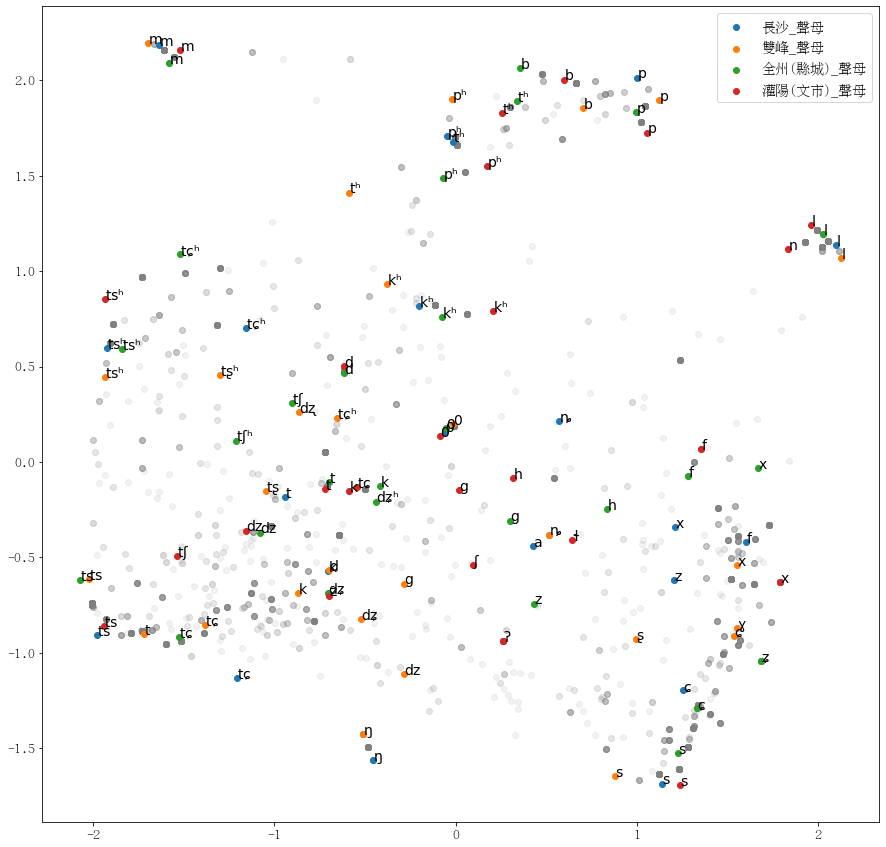

In [118]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['AR PL UMing CN'],
    'axes.unicode_minus': False,
})

pca = PCA(2)
pc = pca.fit_transform(initial_emb)
emb_pc = pca.transform(encoder.embedding.numpy())

fig = plt.figure(figsize=(15, 15))

plt.scatter(pc[:, 0], pc[:, 1], color='gray', alpha=0.1)

for i, col in enumerate(initials):
    plt.scatter(emb_pc[base[i]:base[i + 1], 0], emb_pc[base[i]:base[i + 1], 1], label=col)
    for j, c in enumerate(initial_categories[i]):
        plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_pc[base[i] + j, 0], emb_pc[base[i] + j, 1]))

plt.legend()

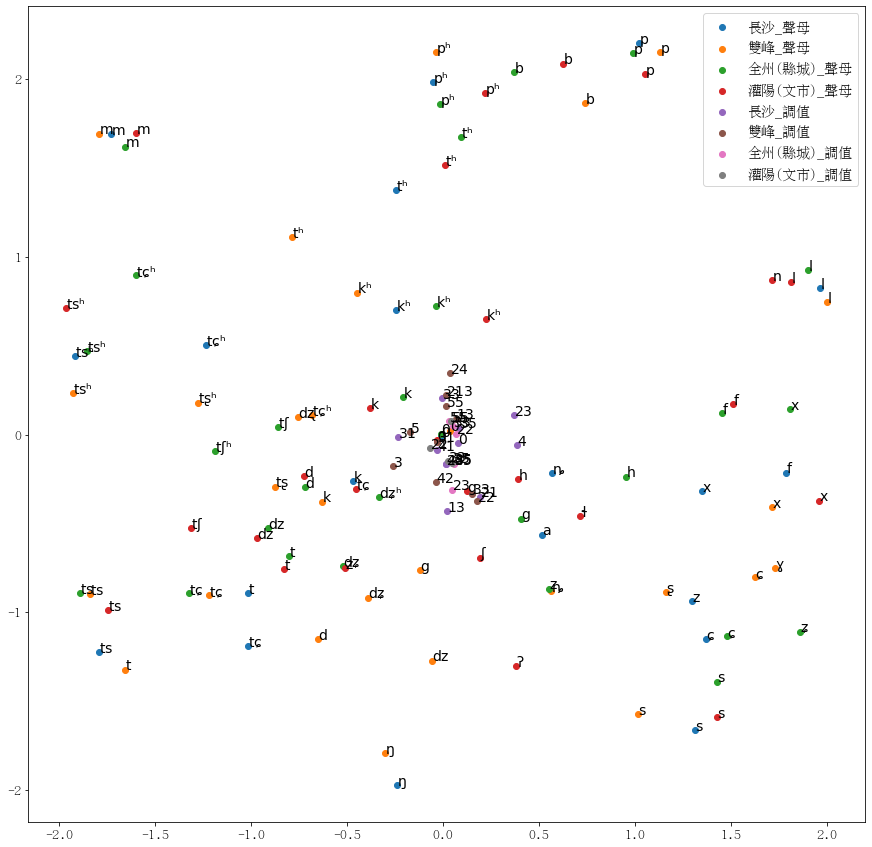

In [146]:
pca = PCA(2)
pca.fit(np.concatenate([encoder.embedding[limits[0]:limits[4]].numpy(), encoder.embedding[limits[8]:limits[12]].numpy()], axis=0))
emb_pc = pca.transform(encoder.embedding.numpy())

fig = plt.figure(figsize=(15, 15))

for i, cols in enumerate((initials, tones)):
    for j, col in enumerate(cols):
        plt.scatter(emb_pc[limits[i * 8 + j]:limits[i * 8 + j + 1], 0], emb_pc[limits[i * 8 + j]:limits[i * 8 + j + 1], 1], label=col)
        for k, c in enumerate(data[col].cat.categories):
            plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_pc[bases[i * 8 + j] + k, 0], emb_pc[bases[i * 8 + j] + k, 1]))

plt.legend()

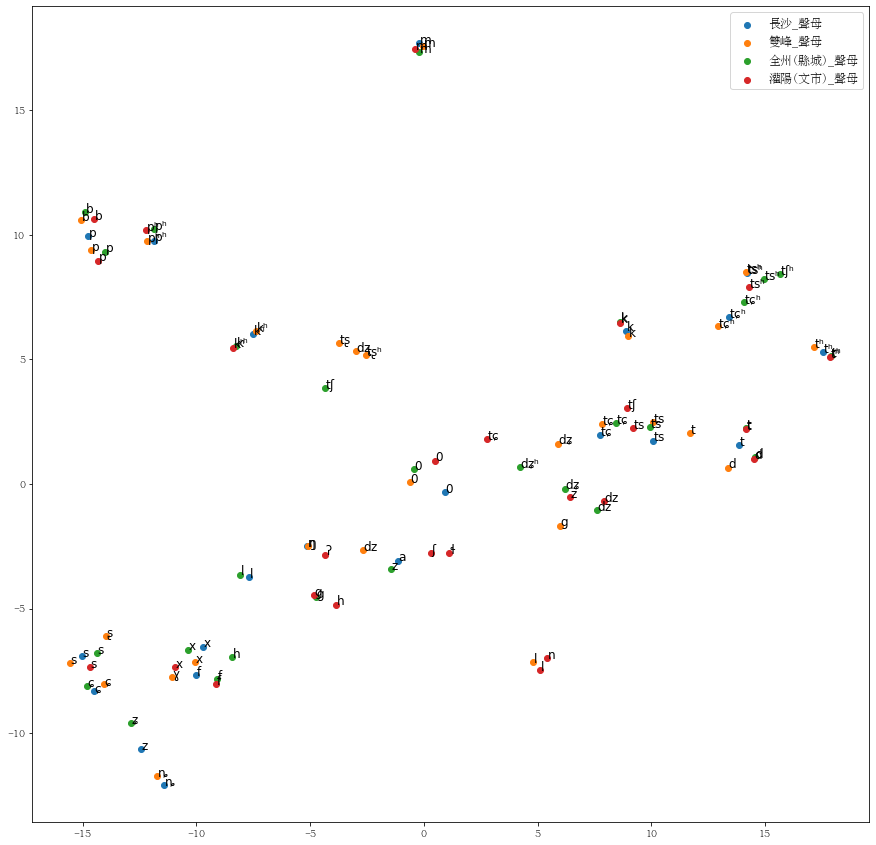

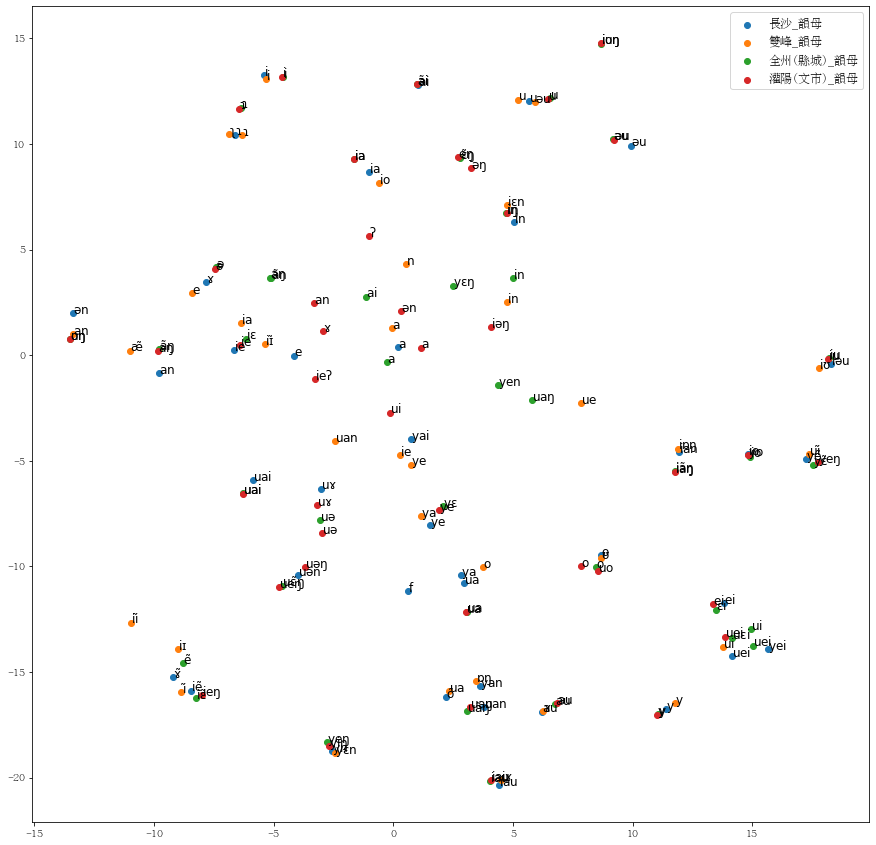

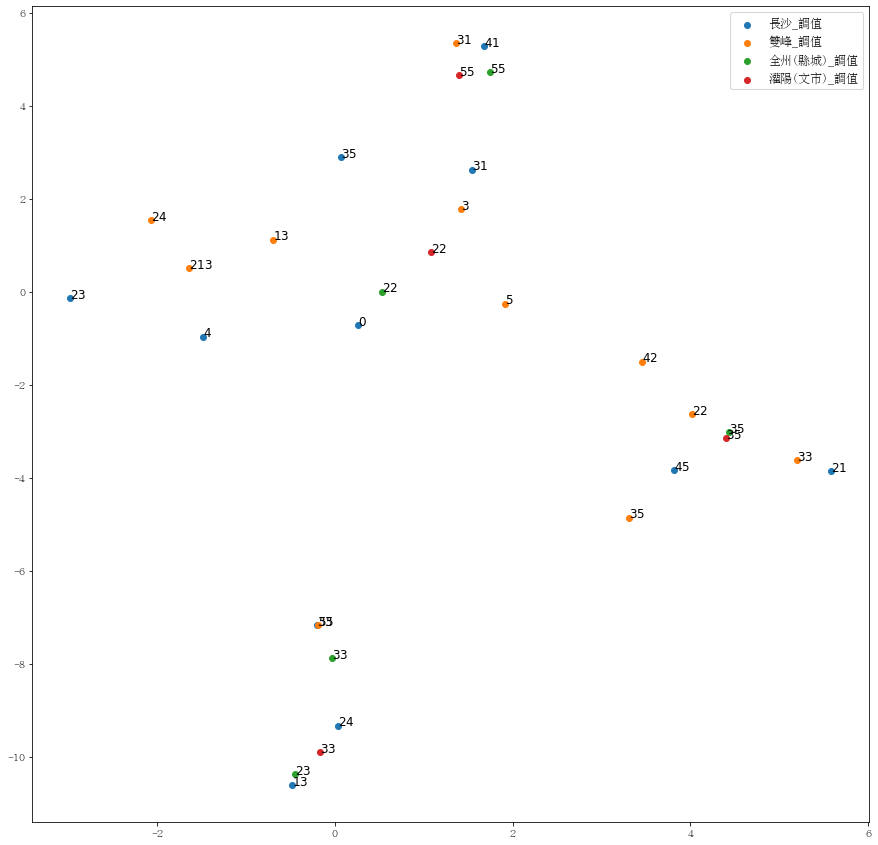

In [147]:
emb_tsne = TSNE(2).fit_transform(encoder.embedding.numpy())

plt.rcParams['font.size'] = 12

for i, cols in enumerate((initials, finals, tones)):
    fig = plt.figure(figsize=(15, 15))

    for j, col in enumerate(cols):
        plt.scatter(emb_tsne[limits[i * 4 + j]:limits[i * 4 + j + 1], 0], emb_tsne[limits[i * 4 + j]:limits[i * 4 + j + 1], 1], label=col)
        for k, c in enumerate(data[col].cat.categories):
            plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_tsne[bases[i * 4 + j] + k, 0], emb_tsne[bases[i * 4 + j] + k, 1]))
    
    plt.legend()

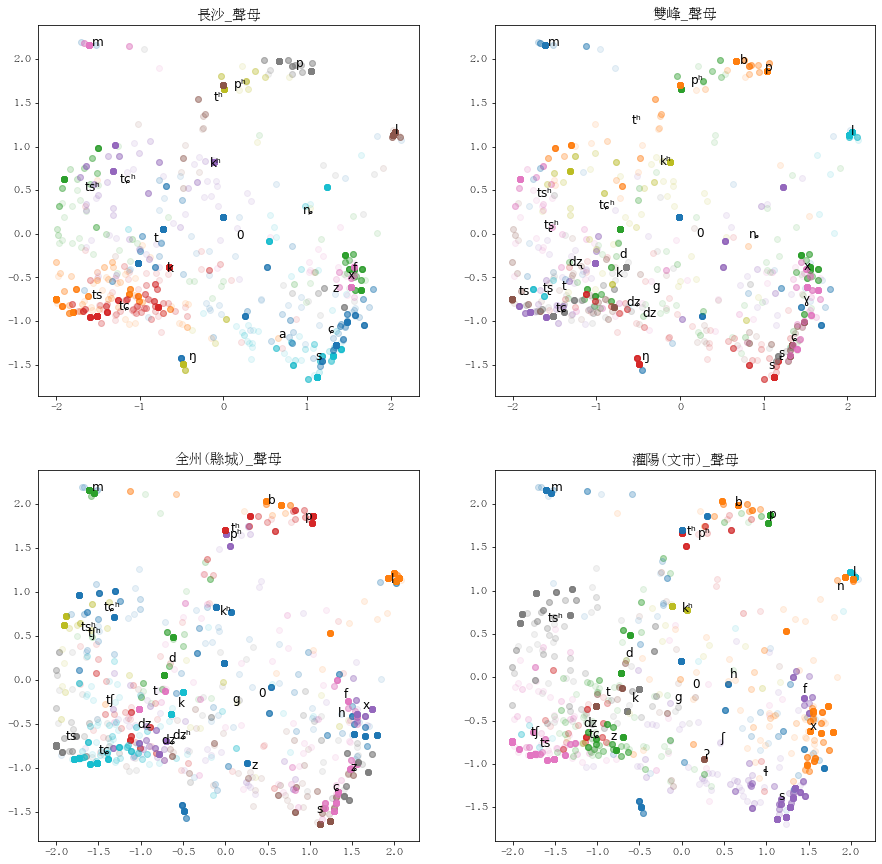

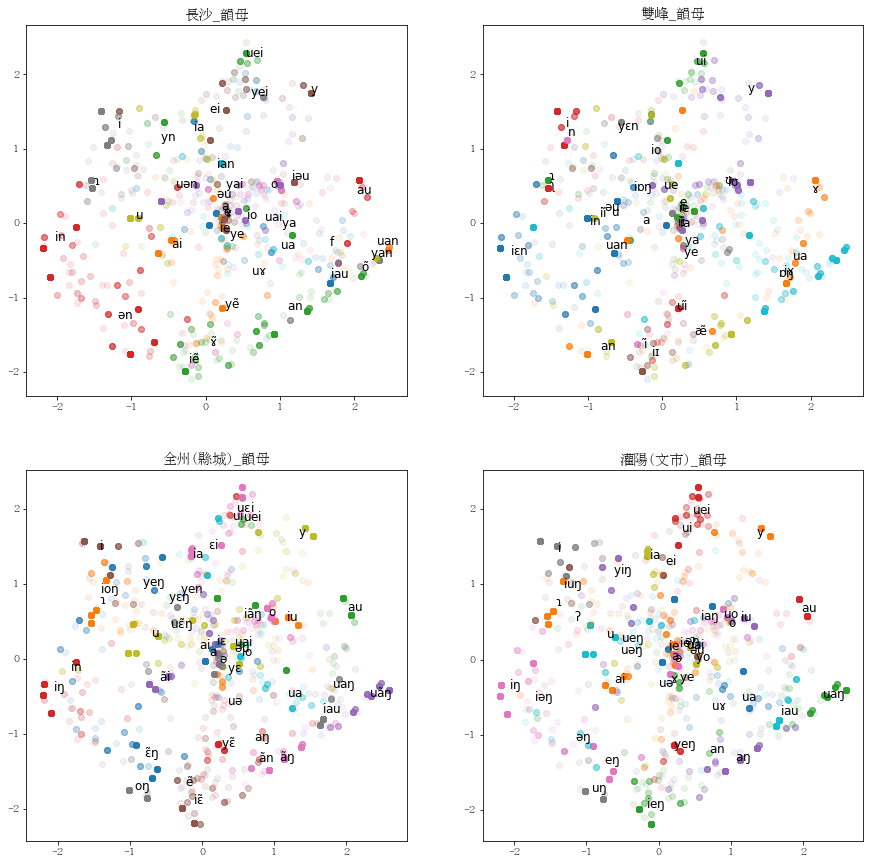

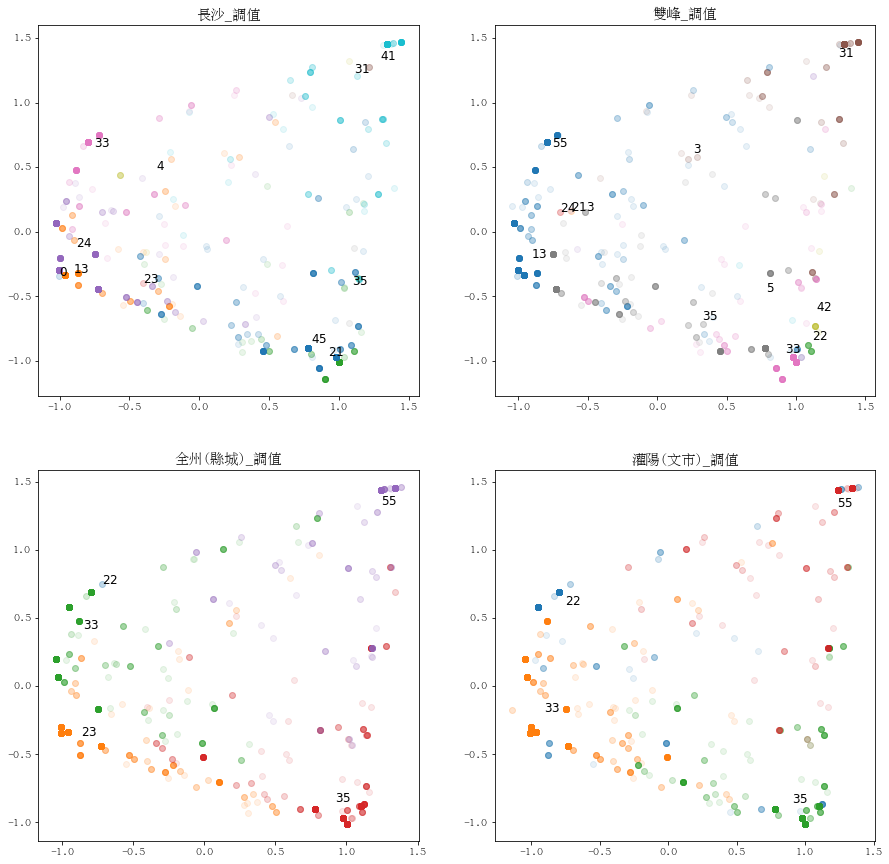

In [148]:
plt.rcParams['font.size'] = 12

for cols, emb in ((initials, initial_emb), (finals, final_emb), (tones, tone_emb)):
    pc = PCA(2).fit_transform(emb)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    axes = (ax1, ax2, ax3, ax4)

    for i, col in enumerate(cols):
        axes[i].set_title(col)
        for c in data[col].cat.categories:
            points = pc[data[col] == c]
            axes[i].scatter(points[:, 0], points[:, 1], alpha=0.1)
            axes[i].annotate(r'$\mathrm{{{}}}$'.format(c), xy=(np.mean(points, axis=0)[0], np.mean(points, axis=0)[1]))
            
    fig.show()

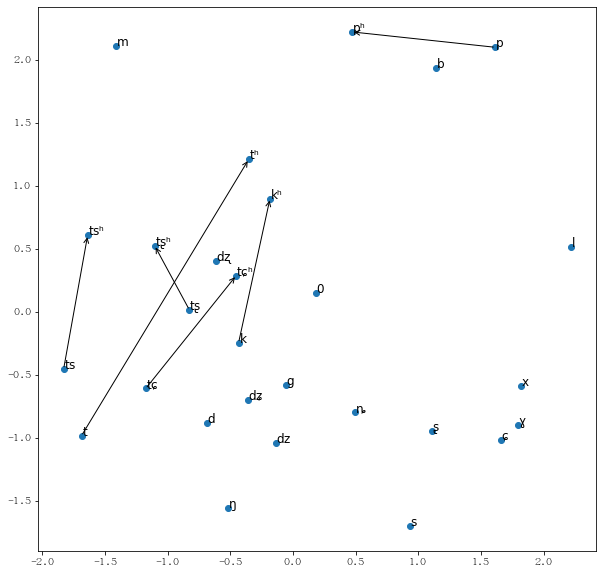

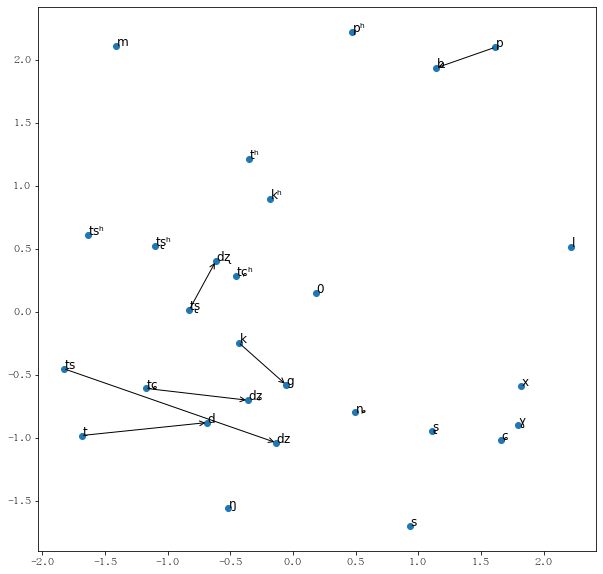

In [191]:
col = 1

pc = PCA(2).fit_transform(encoder.embedding.numpy()[limits[col]:limits[col + 1]])

fig = plt.figure(figsize=(10, 10))
plt.scatter(pc[:, 0], pc[:, 1])

for i, c in enumerate(categories[col]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(pc[i, 0], pc[i, 1]))
    
dic = dict((c, i) for i, c in enumerate(categories[col]))
for group in (
    ('p', 'pʰ'),
    ('t', 'tʰ'),
    ('k', 'kʰ'),
    ('ts', 'tsʰ'),
    ('tʂ', 'tʂʰ'),
    ('tɕ', 'tɕʰ')
):
    idx = np.asarray([dic[c] for c in group])
    plt.annotate('', xytext=(pc[dic[group[0]], 0], pc[dic[group[0]], 1]), xy=(pc[dic[group[1]], 0], pc[dic[group[1]], 1]), arrowprops={'arrowstyle': '->'})
    
fig = plt.figure(figsize=(10, 10))
plt.scatter(pc[:, 0], pc[:, 1])

for i, c in enumerate(categories[col]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(pc[i, 0], pc[i, 1]))
    
fig.show()
    
dic = dict((c, i) for i, c in enumerate(categories[col]))
for group in (
    ('p', 'b'),
    ('t', 'd'),
    ('k', 'g'),
    ('ts', 'dz'),
    ('tʂ', 'dʐ'),
    ('tɕ', 'dʑ')
):
    idx = np.asarray([dic[c] for c in group])
    plt.annotate('', xytext=(pc[dic[group[0]], 0], pc[dic[group[0]], 1]), xy=(pc[dic[group[1]], 0], pc[dic[group[1]], 1]), arrowprops={'arrowstyle': '->'})
    
fig.show()

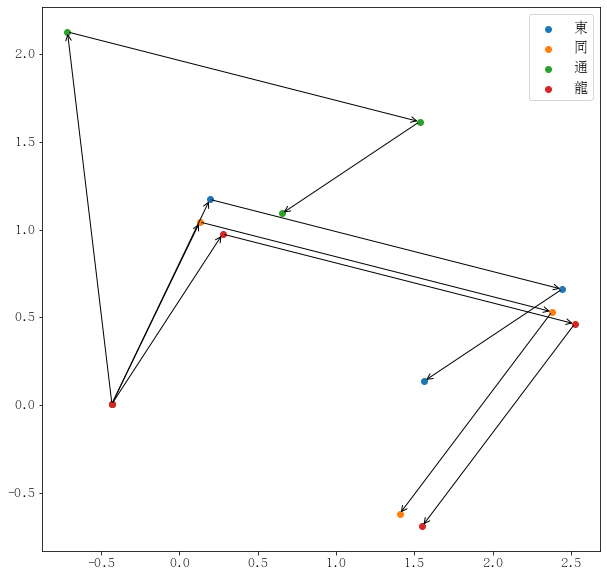

In [143]:
mask = data['字形'].isin(('東', '通', '同', '龍'))

embs = np.stack(
    [np.zeros_like(initial_emb[mask]), initial_emb[mask], final_emb[mask], tone_emb[mask]],
    axis=1
)

points = np.cumsum(embs, axis=1)

pca = PCA(2)
pca.fit(np.reshape(embs, (-1, embs.shape[-1])))

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(10, 10))

for i in range(embs.shape[0]):
    pc = pca.transform(np.cumsum(embs[i], axis=0))
    plt.scatter(pc[:, 0], pc[:, 1], label=data[mask]['字形'].iloc[i])
    for j in range(pc.shape[0] - 1):
        plt.annotate('', xytext=(pc[j, 0], pc[j, 1]), xy=(pc[j + 1, 0], pc[j + 1, 1]), arrowprops={'arrowstyle': '->'})
    
plt.legend()

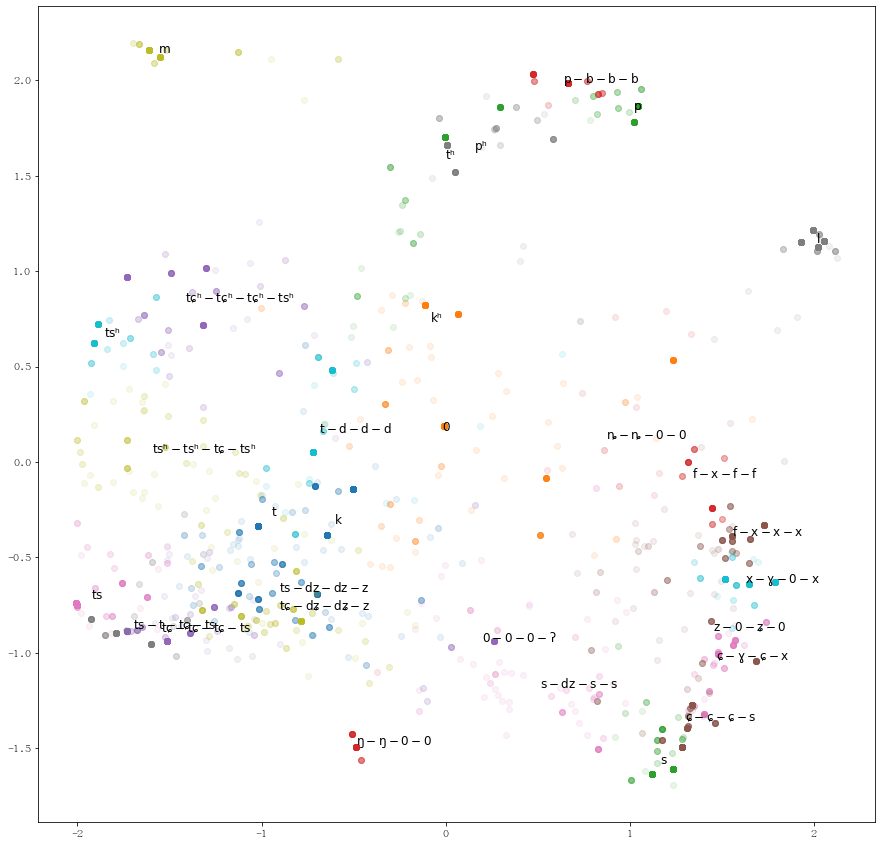

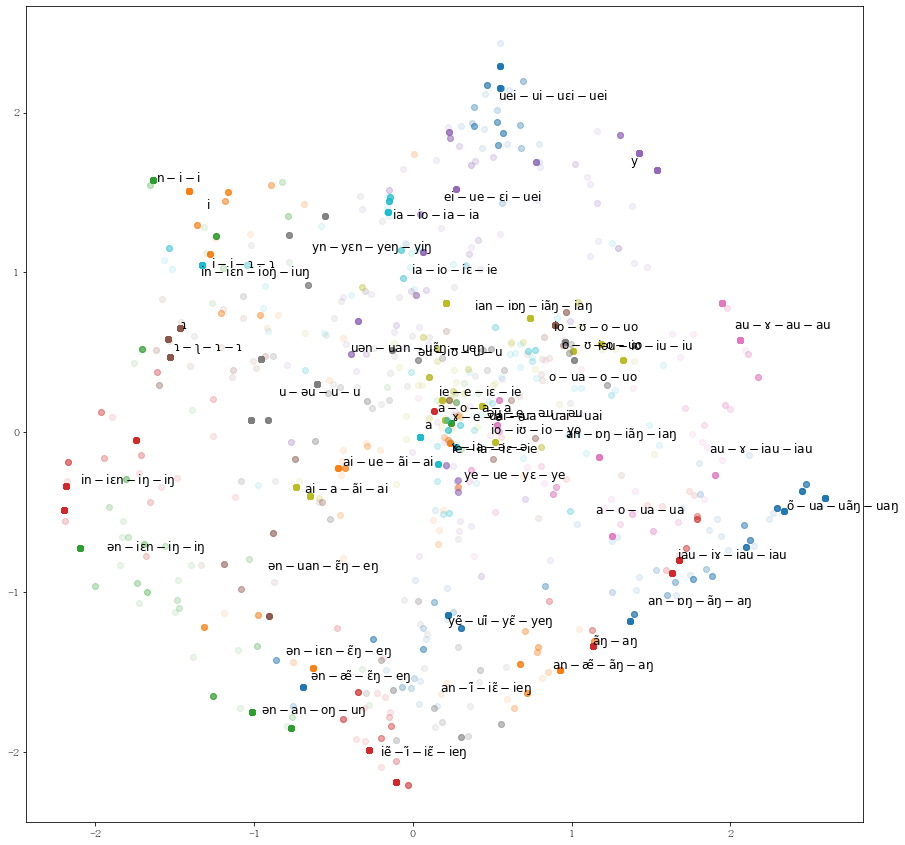

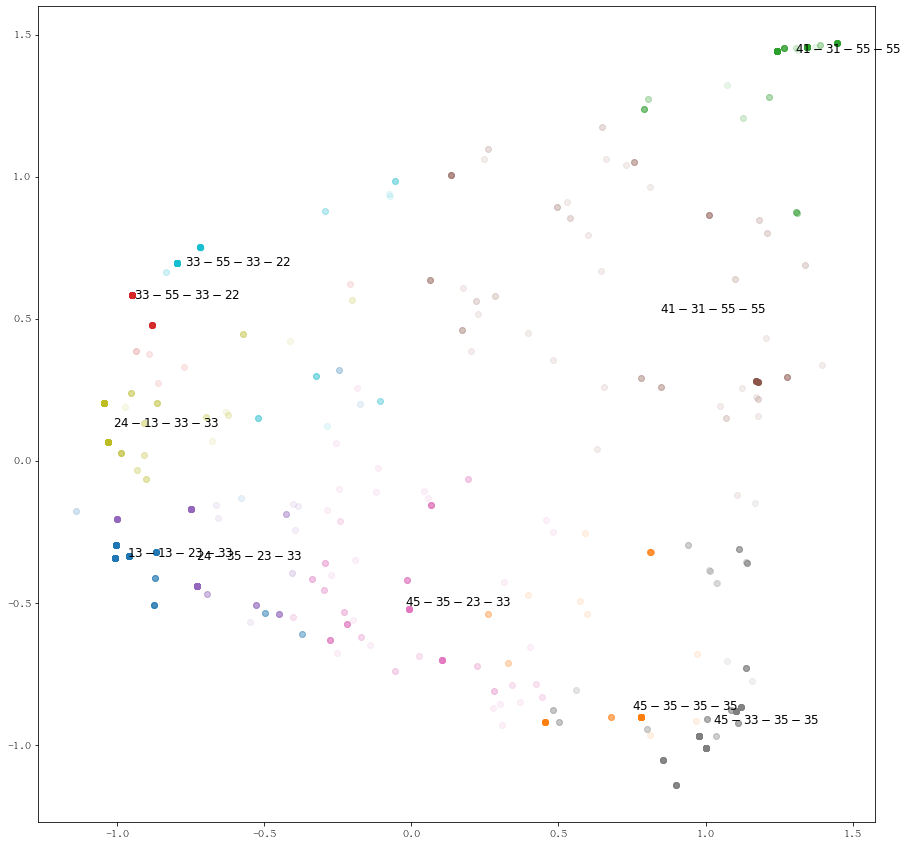

In [149]:
for cols, emb, clusters in ((initials, initial_emb, 30), (finals, final_emb, 50), (tones, tone_emb, 10)):
    pca = PCA(2)
    pc = pca.fit_transform(emb)
    km = KMeans(n_clusters=clusters)
    km.fit(emb)
    center_pc = pca.transform(km.cluster_centers_)

    fit = plt.figure(figsize=(15, 15))
    for i in range(km.cluster_centers_.shape[0]):
        labels = data[km.labels_ == i][cols].mode().iloc[0]
        labels = labels[labels.notna()]
        if len(set(labels)) == 1:
            label = labels.iloc[0]
        else:
            label = '-'.join(labels)
        plt.scatter(pc[km.labels_ == i, 0], pc[km.labels_ == i, 1], alpha=0.1)
        plt.annotate(r'$\mathrm{{{}}}$'.format(label), xy=(center_pc[i, 0], center_pc[i, 1]))

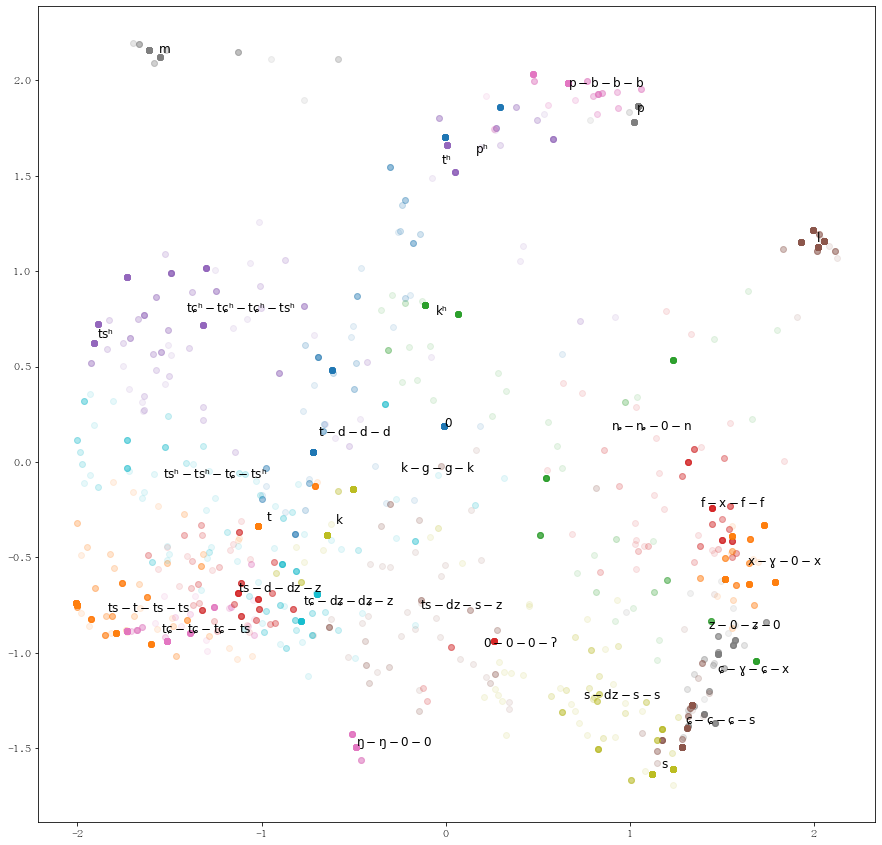

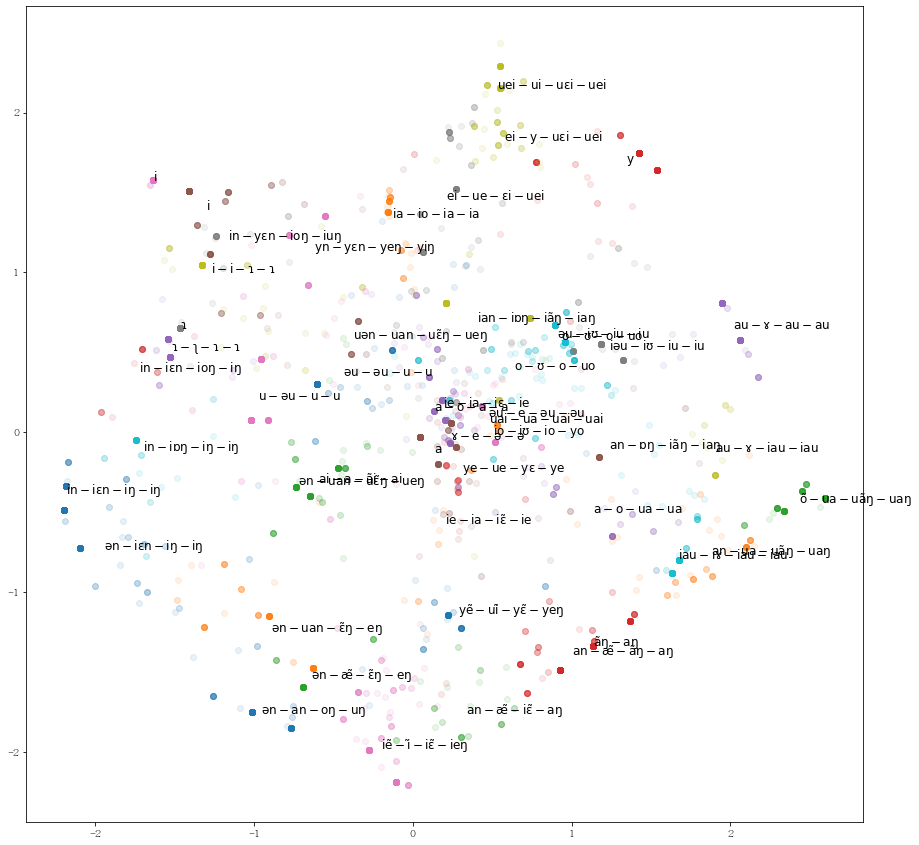

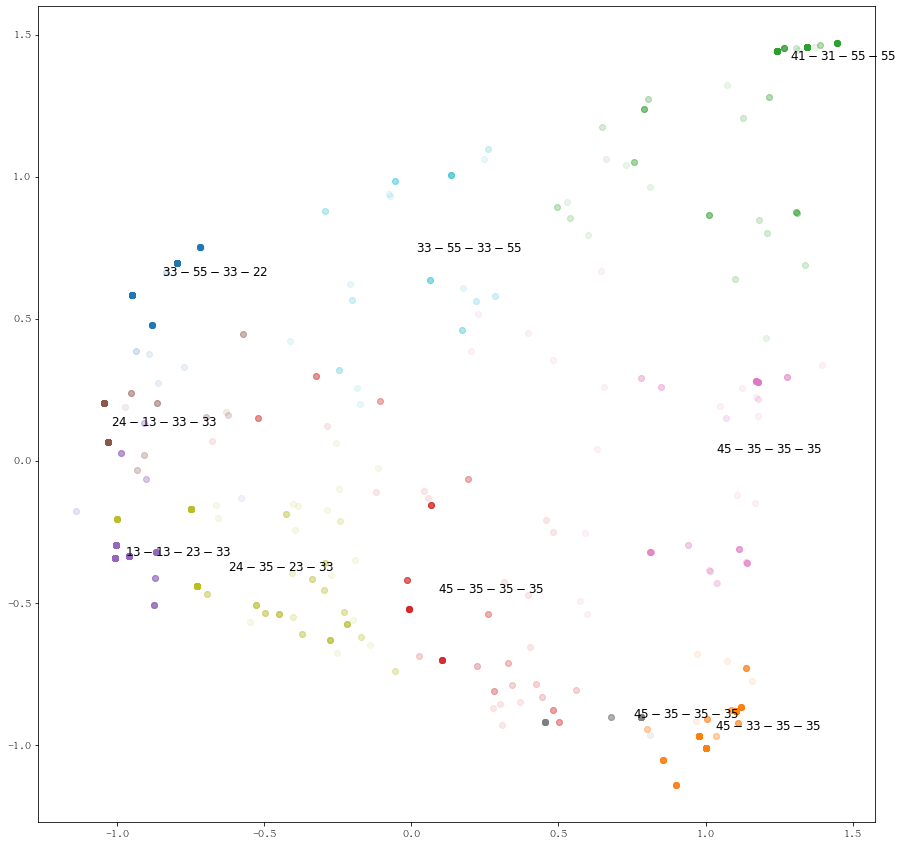

In [150]:
for columns, emb, clusters in ((initials, initial_emb, 30), (finals, final_emb, 50), (tones, tone_emb, 10)):
    pca = PCA(2)
    pc = pca.fit_transform(emb)
    ac = AgglomerativeClustering(n_clusters=clusters)
    ac.fit(emb)

    fit = plt.figure(figsize=(15, 15))
    for i in range(ac.n_clusters_):
        labels = data[ac.labels_ == i][columns].mode().iloc[0]
        labels = labels[labels.notna()]
        if len(set(labels)) == 1:
            label = labels.iloc[0]
        else:
            label = '-'.join(labels)
        plt.scatter(pc[ac.labels_ == i, 0], pc[ac.labels_ == i, 1], alpha=0.1)
        plt.annotate(r'$\mathrm{{{}}}$'.format(label), xy=(np.mean(pc[ac.labels_ == i], axis=0)[0], np.mean(pc[ac.labels_ == i], axis=0)[1]))